In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
!pip install roboflow pycocotools -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.8/89.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 35.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 93.3 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.5.1 which is incompatible.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.40.3 which is incompatible.
google-colab 1.0.0 requires notebook==6.5.7, but you have notebook 6.5.4 which is incompatible.
google-colab 

In [5]:
from roboflow import Roboflow

rf = Roboflow(api_key="tusb0ELv6NJVgtb30lbt")
project = rf.workspace("brad-dwyer").project("pklot-1tros")
dataset = project.version(4).download("coco")

print(f"Dataset downloaded to: {dataset.location}")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to PKLot-4 in coco:: 100%|██████████| 12423/12423 [00:02<00:00, 5811.75it/s]


Dataset downloaded to: /kaggle/working/PKLot-4


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
from PIL import Image
import torchvision.transforms as T
import os
import json

class CocoDataset(Dataset):
    def __init__(self, root, annFile):
        self.coco = COCO(annFile)
        self.root = root
        self.ids = [id for id in self.coco.imgs.keys() if len(self.coco.getAnnIds(imgIds=id)) > 0]
    
    def __getitem__(self, idx):
        img_id = self.ids[idx]
        anns = self.coco.loadAnns(self.coco.getAnnIds(imgIds=img_id))
        
        # Load and ensure RGB (fix grayscale issue)
        img_pil = Image.open(os.path.join(self.root, self.coco.loadImgs(img_id)[0]['file_name']))
        if img_pil.mode != 'RGB':
            img_pil = img_pil.convert('RGB')
        img = T.ToTensor()(img_pil)
        
        boxes = [[x, y, x+w, y+h] for x, y, w, h in [a['bbox'] for a in anns] if w > 0 and h > 0]
        return img, {"boxes": torch.tensor(boxes, dtype=torch.float32), "labels": torch.tensor([a['category_id'] for a in anns], dtype=torch.int64)}
    
    def __len__(self):
        return len(self.ids)

path = dataset.location
coco_data = json.load(open(f"{path}/train/_annotations.coco.json"))
num_classes = len(coco_data['categories']) + 1  # +1 for background (Faster R-CNN needs this)
class_names = [cat['name'] for cat in coco_data['categories']]

train_loader = DataLoader(CocoDataset(f"{path}/train", f"{path}/train/_annotations.coco.json"), 
                          batch_size=16, shuffle=True, collate_fn=lambda x: tuple(zip(*x)), num_workers=2)

print(f"Number of classes (including background): {num_classes}")
print(f"Your dataset classes: {class_names}")

loading annotations into memory...
Done (t=2.81s)
creating index...
index created!
Number of classes (including background): 4
Your dataset classes: ['spaces', 'space-empty', 'space-occupied']


In [11]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"GPUs available: {torch.cuda.device_count()}")

# Load Faster R-CNN
model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
model.roi_heads.box_predictor = FastRCNNPredictor(
    model.roi_heads.box_predictor.cls_score.in_features, num_classes
)

# DON'T use DataParallel - it causes issues with Faster R-CNN
# Just use single GPU (still fast with batch_size=16)
model.to(device)

print("Using single GPU (DataParallel doesn't work well with Faster R-CNN)")

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

print("Training Faster R-CNN...")
for epoch in range(10):
    model.train()
    for i, (images, targets) in enumerate(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        losses = sum(loss for loss in model(images, targets).values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        if (i + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/10, Step {i+1}/{len(train_loader)}, Loss: {losses.item():.4f}")

torch.save(model.state_dict(), "faster_rcnn_model.pth")
print("Training complete!")

Device: cuda
GPUs available: 2
Using single GPU (DataParallel doesn't work well with Faster R-CNN)
Training Faster R-CNN...
Epoch 1/10, Step 10/532, Loss: 1.4827
Epoch 1/10, Step 20/532, Loss: 1.0930
Epoch 1/10, Step 30/532, Loss: 0.9781
Epoch 1/10, Step 40/532, Loss: 0.8668
Epoch 1/10, Step 50/532, Loss: 0.7460
Epoch 1/10, Step 60/532, Loss: 0.6468
Epoch 1/10, Step 70/532, Loss: 0.5680
Epoch 1/10, Step 80/532, Loss: 0.5698
Epoch 1/10, Step 90/532, Loss: 0.5646
Epoch 1/10, Step 100/532, Loss: 0.5109
Epoch 1/10, Step 110/532, Loss: 0.4969
Epoch 1/10, Step 120/532, Loss: 0.4670
Epoch 1/10, Step 130/532, Loss: 0.4065
Epoch 1/10, Step 140/532, Loss: 0.4065
Epoch 1/10, Step 150/532, Loss: 0.3961
Epoch 1/10, Step 160/532, Loss: 0.3958
Epoch 1/10, Step 170/532, Loss: 0.3855
Epoch 1/10, Step 180/532, Loss: 0.3868
Epoch 1/10, Step 190/532, Loss: 0.3779
Epoch 1/10, Step 200/532, Loss: 0.4429
Epoch 1/10, Step 210/532, Loss: 0.3399
Epoch 1/10, Step 220/532, Loss: 0.2825
Epoch 1/10, Step 230/532, L

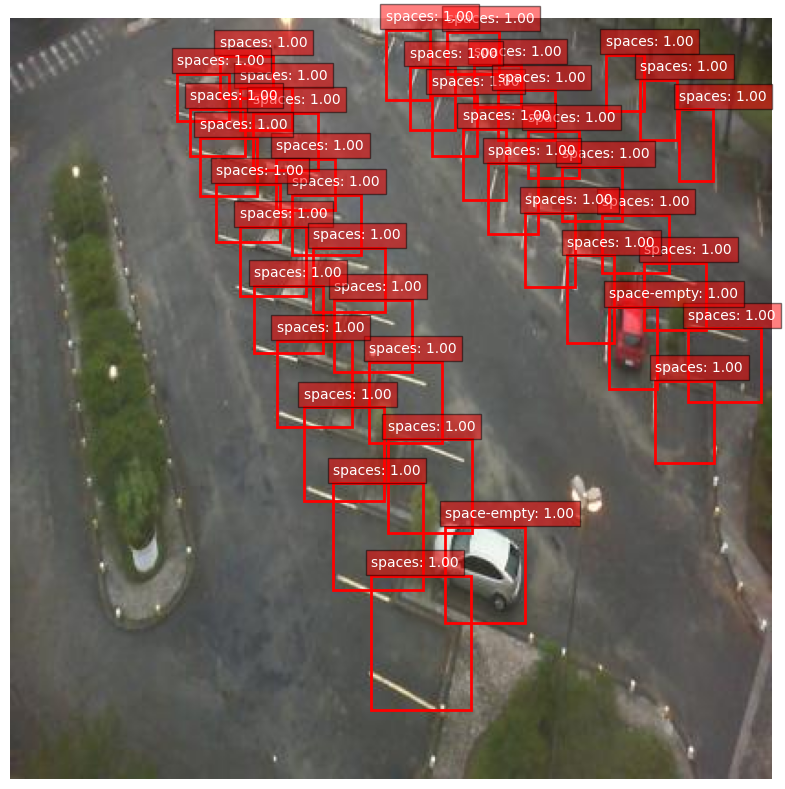

Detected 40 objects


In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

model.eval()

test_dir = f"{path}/test"
test_images = [f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
test_img_path = os.path.join(test_dir, test_images[0])

img = Image.open(test_img_path).convert("RGB")

with torch.no_grad():
    pred = model([T.ToTensor()(img).to(device)])[0]

threshold = 0.5
keep = pred['scores'] > threshold
boxes = pred['boxes'][keep].cpu().numpy()
scores = pred['scores'][keep].cpu().numpy()
labels = pred['labels'][keep].cpu().numpy()

fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(img)

for box, score, label in zip(boxes, scores, labels):
    x1, y1, x2, y2 = box
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                            linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    
    class_name = class_names[label-1] if label > 0 else "background"
    ax.text(x1, y1-5, f"{class_name}: {score:.2f}", 
           bbox=dict(facecolor='red', alpha=0.5), fontsize=10, color='white')

plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Detected {len(boxes)} objects")

In [14]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

# First, save your model
checkpoint = {
    'model_state_dict': model.state_dict(),
    'class_names': class_names,
    'num_classes': len(class_names) + 1,
}
torch.save(checkpoint, '/kaggle/working/faster_rcnn_model.pth')
print("Model saved!")

# Now download it
download_file('faster_rcnn_model.pth', 'faster_rcnn_model')

Model saved!


/kaggle/working/faster_rcnn_model.zip